In [1]:
!pip install pydot==3.0.3 \
            graphviz==0.20.3 \
            tensorflow==2.15.0 \
            scikit-learn==1.5.2 \
            matplotlib==3.8.0 \
            seaborn==0.13.2 \
            Pillow==11.0.0 \
            pandas==2.2.2 \
            numpy==1.26.4 \
            ipywidgets==8.1.5

## Import Library

In [2]:
from google.colab import files
import numpy as np
import pandas as pd
from google.colab import drive
from zipfile import ZipFile
import os, shutil
import glob

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage
from google.colab import files
# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2, DenseNet121, ResNet50
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, AdamW
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc

In [3]:
print(tf.__version__)

2.15.0


In [4]:
# Menghubungkan drive ke gogle colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Menyalin file dari "Shared with me" perlu menggunakan PyDrive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autentikasi dan inisialisasi PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive_pydrive = GoogleDrive(gauth)

# Temukan file berdasarkan nama (harus publik atau dibagikan ke kamu)
file_list = drive_pydrive.ListFile({'q': "title='dataset_gambar1.zip' and trashed=false"}).GetList()
for file in file_list:
    print('Menyalin:', file['title'], file['id'])
    file.GetContentFile(f"/content/{file['title']}")


Menyalin: dataset_gambar1.zip 1XUR76K8kIVw7nfqwSaWp1ZLLw5oDeYTT


## Load Dataset

In [6]:
file_name = "/content/dataset_gambar1.zip"

if os.path.exists(file_name):
    with ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset_gambar1/')  # folder tujuan ekstraksi
        print("Ekstraksi selesai.")
else:
    print("File ZIP tidak ditemukan. Pastikan path-nya benar.")

Ekstraksi selesai.


In [7]:
base_path = "/content/dataset_gambar1/dataset_gambar"

# Menelusuri seluruh file dari train, valid, test
for split in ['train', 'valid', 'test']:
    folder_path = os.path.join(base_path, split)
    print(f"\nIsi folder '{split}':")

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            print(file_path)


Isi folder 'train':
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_283.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_157.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_378.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_329.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_110.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_274.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_089.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_276.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_196.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_490.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_219.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_334.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_191.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Pizza_324.jpg
/content/dataset_gambar1/dataset_gambar/train/Pizza/Piz

## Data Praprocessing dan Data Augmented

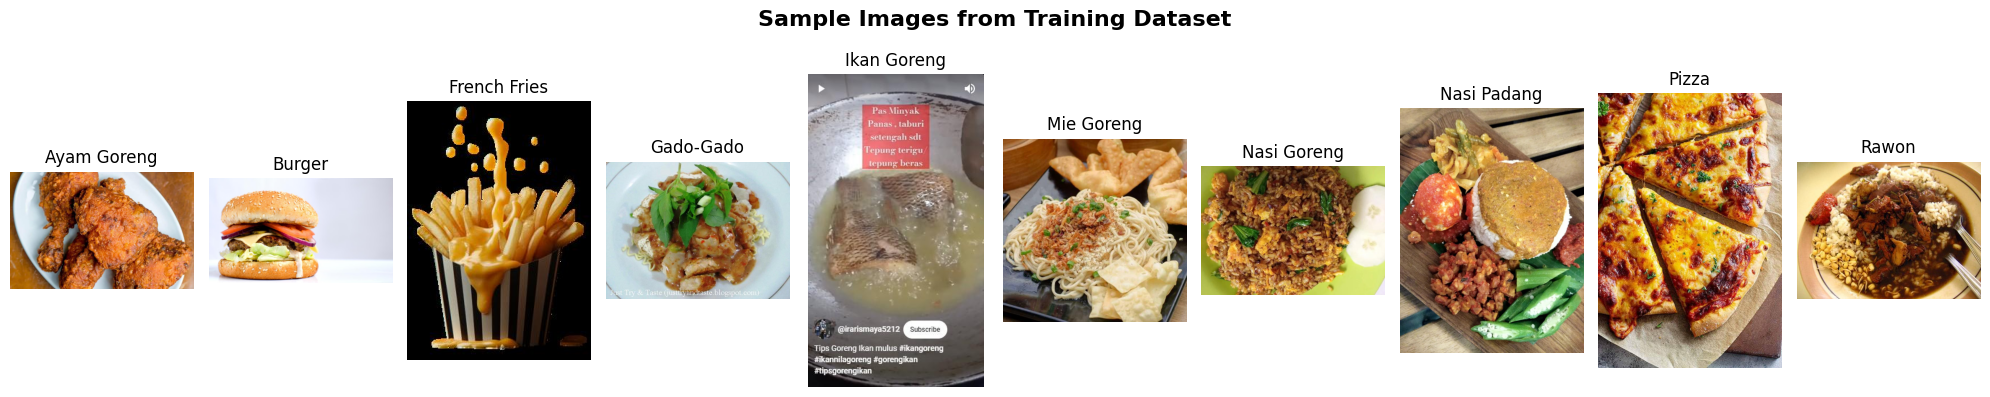

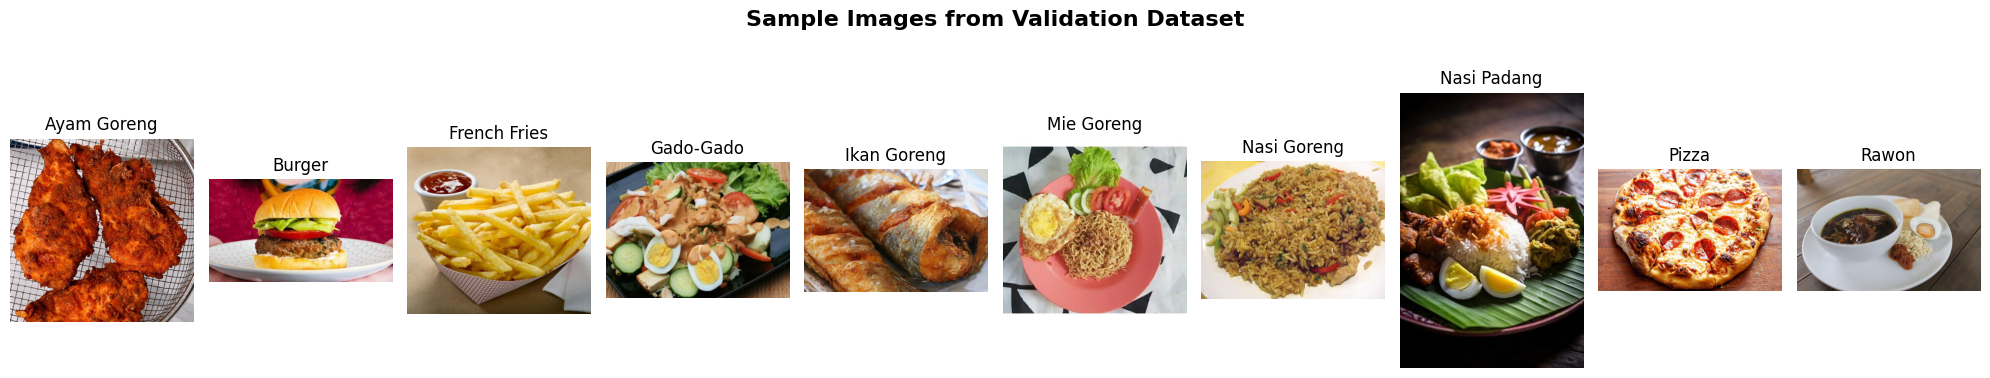

In [8]:
# Direktori asal untuk train dan test
train_dir = "dataset_gambar1/dataset_gambar/train"
test_dir = "dataset_gambar1/dataset_gambar/test"
valid_dir = "dataset_gambar1/dataset_gambar/valid"

# Fungsi menampilkan 1 gambar per kelas
def display_sample_image_from_directory(directory, ax):
    class_names = sorted([
        class_name for class_name in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, class_name))
    ])[:10]  # Ambil hanya 10 kelas pertama

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        if not image_files:
            continue
        image_path = os.path.join(class_path, image_files[0])
        img = mpimg.imread(image_path)
        ax[i].imshow(img)
        ax[i].set_title(class_name)
        ax[i].axis('off')

# Fungsi membuat plot sample per dataset
def plot_sample_images(directory, title):
    fig, axes = plt.subplots(1, 10, figsize=(20, 4))
    display_sample_image_from_directory(directory, axes)
    fig.suptitle(title, fontsize=16, weight='bold')
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)
    plt.tight_layout()
    plt.subplots_adjust(top=0.82)
    plt.show()

# Plot untuk dataset Train dan Valid
plot_sample_images(train_dir, 'Sample Images from Training Dataset')
plot_sample_images(valid_dir, 'Sample Images from Validation Dataset')

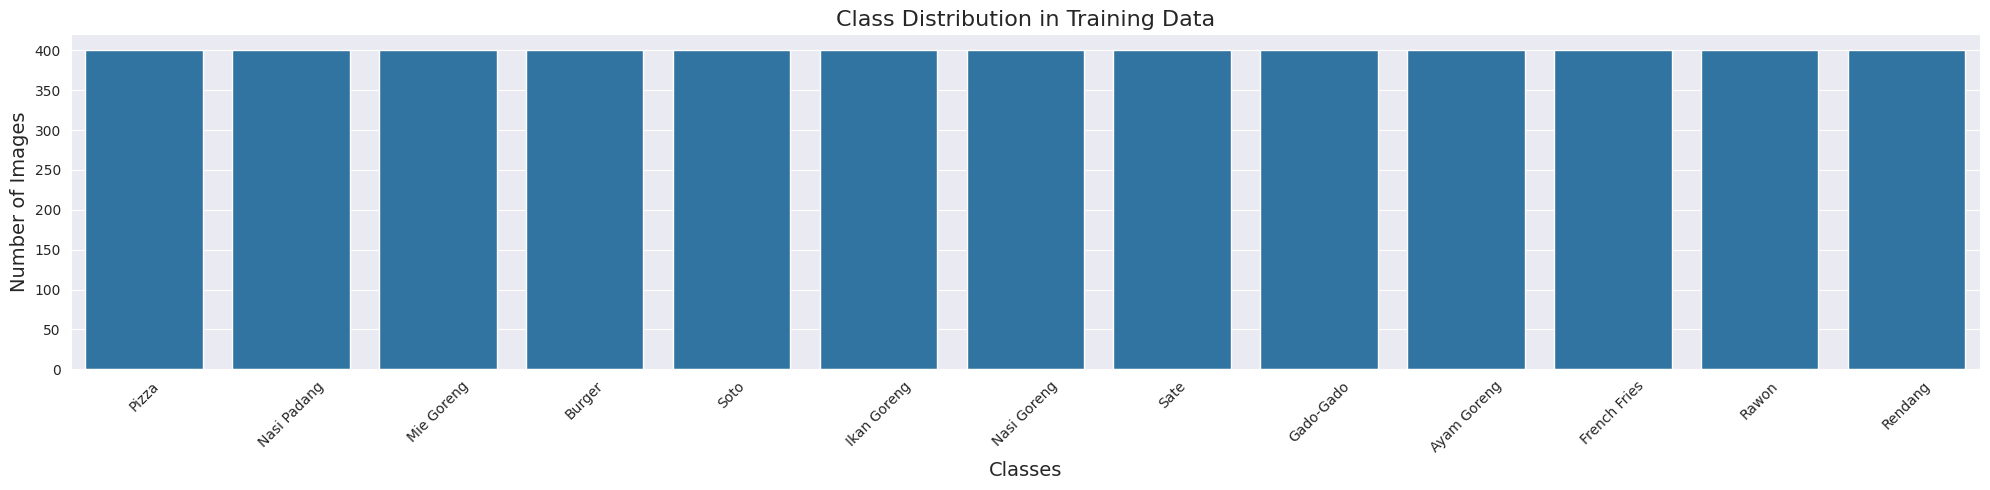

In [9]:
# Descriptive Statistics Visualization
# Retrieve the number of images per class
image_files = glob.glob(train_dir + '/*/*')
class_labels = [os.path.basename(os.path.dirname(file)) for file in image_files]
class_counts = pd.Series(class_labels).value_counts()

# Visualize the class distribution
plt.figure(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Training Data', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Display descriptive statistics for image counts
print("Descriptive Statistics for Image Counts:")
print(class_counts.describe())

Descriptive Statistics for Image Counts:
count     13.0
mean     400.0
std        0.0
min      400.0
25%      400.0
50%      400.0
75%      400.0
max      400.0
Name: count, dtype: float64


In [11]:
# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# ImageDataGenerator dengan augmentasi + validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # split data train menjadi training dan validation
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=(0.7, 1.3),
    channel_shift_range=20.0
)

# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
)

# Generator untuk data training
val_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data validasi
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
)

# Generator untuk data test (tanpa augmentasi, hanya rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

Found 4158 images belonging to 13 classes.
Found 1035 images belonging to 13 classes.
Found 648 images belonging to 13 classes.


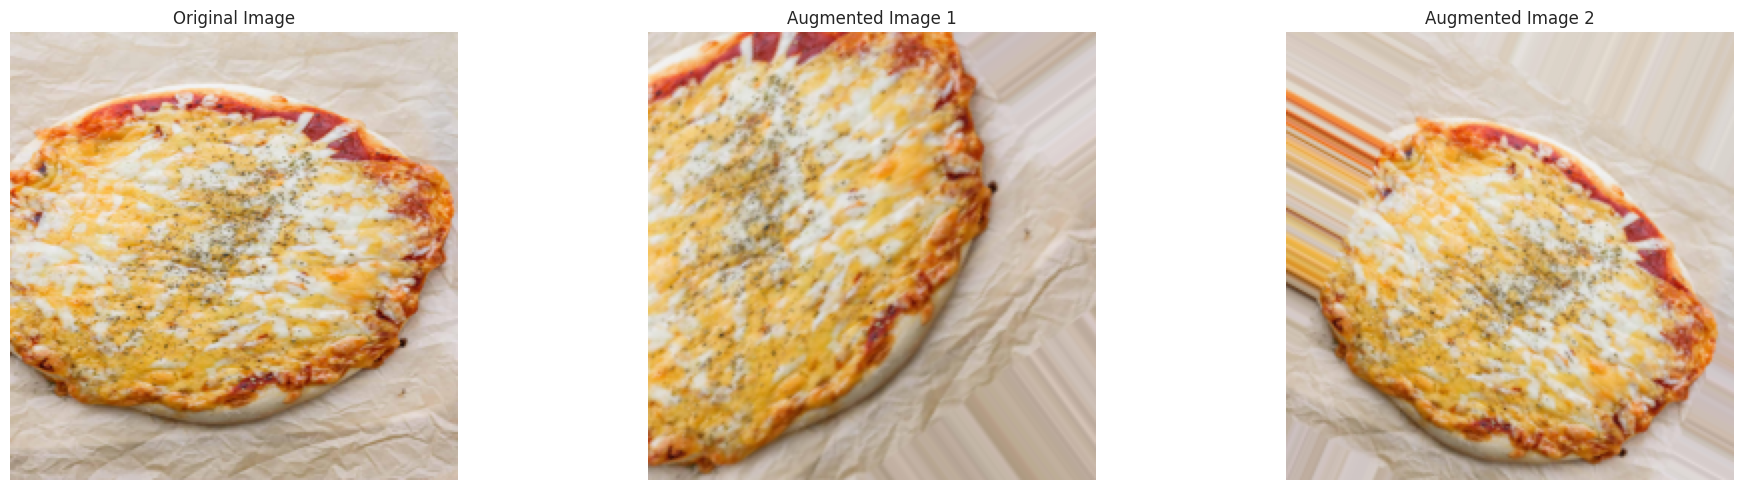

In [12]:
# Load and preprocess image
sample_image = np.array(Image.open(image_files[5]).resize(IMAGE_SIZE)) / 255.0
sample_image = sample_image.reshape((1,) + sample_image.shape)

# Set up ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

# Generate augmented images
augmented_images = [sample_image[0]] + [next(datagen.flow(sample_image, batch_size=1))[0] for _ in range(2)]

# Plot original and augmented images
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
titles = ["Original Image", "Augmented Image 1", "Augmented Image 2"]
for i, img in enumerate(augmented_images):
    ax[i].imshow(img)
    ax[i].set_title(titles[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Melatih Model

In [13]:
# Menggunakan Model MobileNetV2
# Define Attention Module
def attention_module(inputs):
    # Attention mechanism using a simple dot-product attention
    attention = layers.Attention()([inputs, inputs])
    return attention

def attention_module(inputs):
    # Expand dimensions to make inputs compatible with Attention layer
    inputs_expanded = tf.expand_dims(inputs, axis=1)  # Add sequence length dimension
    attention = layers.Attention()([inputs_expanded, inputs_expanded])
    return tf.squeeze(attention, axis=1)  # Remove the sequence length dimension

# Define the Fine-Tuned Model
def create_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

    # Fine-Tuning: Unfreeze the last 4 layers of MobileNetV2
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Multi-Branch Architecture
    input = layers.Input(shape=(224, 224, 3))

    # Branch 1 - CNN Layers with Residual Connections
    x1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D()(x1)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D()(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)

    # Branch 2 - MobileNetV2 as feature extractor
    x2 = base_model(input)
    x2 = layers.GlobalAveragePooling2D()(x2)

    # Flatten both x1 and x2
    x1 = layers.Flatten()(x1)
    x2 = layers.Flatten()(x2)

    # Ensure both branches have the same shape by adding Dense layers if necessary
    x1_shape = x1.shape[-1]
    x2_shape = x2.shape[-1]

    if x1_shape != x2_shape:
        if x1_shape < x2_shape:
            x1 = layers.Dense(x2_shape, activation='relu')(x1)
        else:
            x2 = layers.Dense(x1_shape, activation='relu')(x2)

    # Attention Layer
    x2 = attention_module(x2)

    # Merging Branches with Enhanced Fine-Tuning
    x = layers.concatenate([x1, x2])

    # Add more Dense layers and Batch Normalization
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)

    # Additional Dense layer with LeakyReLU activation
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.Dropout(0.5)(x)

    # Additional layer to decrease dimension gradually
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.Dropout(0.4)(x)

    # Output Layer
    output = layers.Dense(len(train_generator.class_indices), activation='softmax')(x)

    # Build and compile model
    model = models.Model(inputs=input, outputs=output)
    model.compile(optimizer=Nadam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['accuracy'])

    return model

# Create and summarize the model
classification_model = create_model()

classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)         0         ['batch_normalization[0][0

In [14]:
# Path ke Google Drive
save_path = '/content/drive/MyDrive/Model/basemodel.h5'

# Buat folder jika belum ada
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Callback untuk menyimpan model terbaik ke Google Drive
checkpoint_cb = ModelCheckpoint(
    filepath=save_path,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Callback untuk menghentikan pelatihan jika val_accuracy stagnan
early_stopping_cb = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.005,
    patience=7,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# Callback untuk mengurangi learning rate jika val_loss stagnan
reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6,
    mode='min'
)

# Jumlah sampel dan epoch
num_samples = train_generator.samples
num_epochs = 50

# Latih model dengan callbacks
history = classification_model.fit(
    train_generator,
    steps_per_epoch=num_samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=num_epochs,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)


Epoch 1/50
129/129 [==============================] - ETA: 0s - loss: 3.4008 - accuracy: 0.2441
Epoch 1: val_loss improved from inf to 1.34130, saving model to /content/drive/MyDrive/Model/basemodel.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 136s 1s/step - loss: 3.4008 - accuracy: 0.2441 - val_loss: 1.3413 - val_accuracy: 0.6602 - lr: 1.0000e-04
Epoch 2/50
129/129 [==============================] - ETA: 0s - loss: 2.0060 - accuracy: 0.4588
Epoch 2: val_loss improved from 1.34130 to 0.77710, saving model to /content/drive/MyDrive/Model/basemodel.h5
129/129 [==============================] - 128s 995ms/step - loss: 2.0060 - accuracy: 0.4588 - val_loss: 0.7771 - val_accuracy: 0.7627 - lr: 1.0000e-04
Epoch 3/50
129/129 [==============================] - ETA: 0s - loss: 1.5684 - accuracy: 0.5674
Epoch 3: val_loss improved from 0.77710 to 0.64476, saving model to /content/drive/MyDrive/Model/basemodel.h5
129/129 [==============================] - 127s 985ms/step - loss: 1.5684 - accuracy: 0.5674 - val_loss: 0.6448 - val_accuracy: 0.7920 - lr: 1.0000e-04
Epoch 4/50
129/129 [==============================] - ETA: 0s - loss: 1.3598 - accuracy: 0.6163
Epoch 4: val_loss improved from 0.64476

## Visualisasi dan Validasi

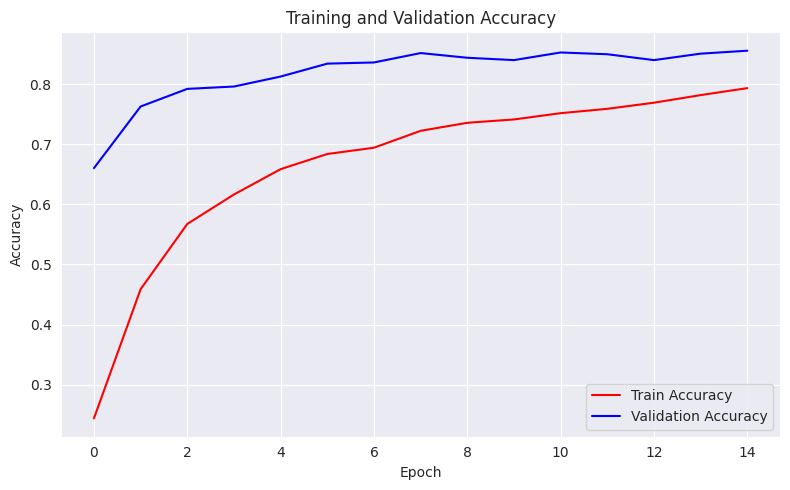

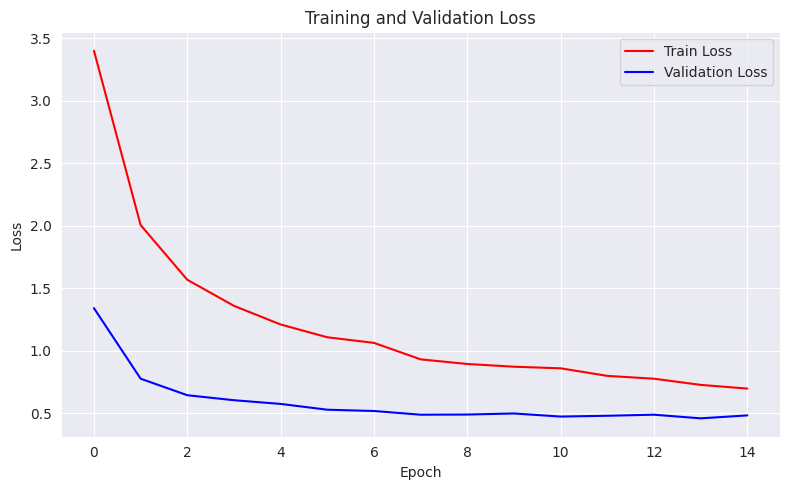

In [15]:
def plot_history(history):
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(len(acc))

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, 'r-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'r-', label='Train Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_history(history)

21/21 [==============================] - 8s 353ms/step


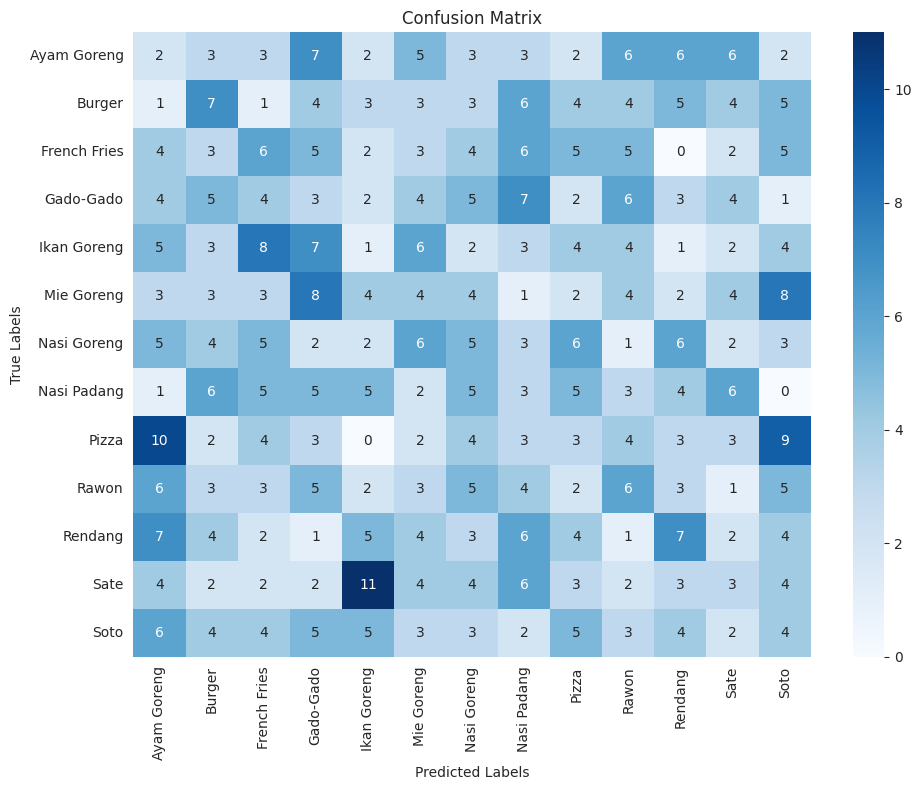

Classification Report:
               precision    recall  f1-score   support

 Ayam Goreng       0.03      0.04      0.04        50
      Burger       0.14      0.14      0.14        50
French Fries       0.12      0.12      0.12        50
   Gado-Gado       0.05      0.06      0.06        50
 Ikan Goreng       0.02      0.02      0.02        50
  Mie Goreng       0.08      0.08      0.08        50
 Nasi Goreng       0.10      0.10      0.10        50
 Nasi Padang       0.06      0.06      0.06        50
       Pizza       0.06      0.06      0.06        50
       Rawon       0.12      0.12      0.12        48
     Rendang       0.15      0.14      0.14        50
        Sate       0.07      0.06      0.07        50
        Soto       0.07      0.08      0.08        50

    accuracy                           0.08       648
   macro avg       0.08      0.08      0.08       648
weighted avg       0.08      0.08      0.08       648



In [16]:
# Prediksi pada test set
y_pred = classification_model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Label ground truth
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes,
                                target_names=list(test_generator.class_indices.keys()))
print("Classification Report:\n", report)


## Evaluasi Model

In [17]:
# Evaluasi model pada test dataset
test_loss, test_accuracy = classification_model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE,
    verbose=1
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


20/20 [==============================] - 7s 357ms/step - loss: 0.4224 - accuracy: 0.8609
Test Loss: 0.4224
Test Accuracy: 0.8609


## Infrence Model

In [18]:
def predict_from_test_folder(test_folder_path, model):
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_folder_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=None,      # Tidak ada label karena hanya prediksi
        shuffle=False         # Penting agar urutan file tetap
    )

    # Prediksi dengan model
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_class_indices = np.argmax(predictions, axis=1)

    # Mapping indeks ke nama kelas
    class_labels = list(test_generator.class_indices.keys())
    predicted_class_names = [class_labels[i] for i in predicted_class_indices]

    # Print hasil prediksi per file
    for filename, class_name in zip(test_generator.filenames, predicted_class_names):
        print(f'File: {filename} -> Predicted Class: {class_name}')

# Panggil fungsi ini dengan variabel yang sudah ada
predict_from_test_folder(test_dir, classification_model)

Found 648 images belonging to 13 classes.
21/21 [==============================] - 8s 337ms/step
File: Ayam Goreng/Ayam Goreng_010.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_011.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_013.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_019.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_025.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_035.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_036.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_043.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_053.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_081.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_082.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_090.jpg -> Predicted Class: Ayam Goreng
File: Ayam Goreng/Ayam Goreng_097.jpg -> Predicted Class: Ayam 

Mencoba memuat model dari: /content/drive/MyDrive/Model/basemodel.h5
Model berhasil dimuat.

--- Contoh Prediksi Satu Gambar Lokal ---

🖼️ Gambar yang akan diprediksi: /content/dataset_gambar1/dataset_gambar/train/Ayam Goreng/Ayam Goreng_001.jpg


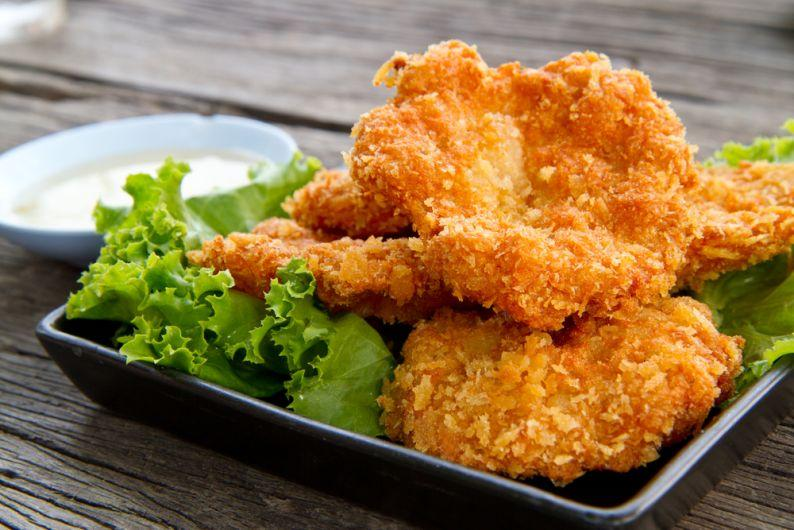

🔍 Prediksi Kelas: **Ayam Goreng**
📈 Keyakinan (Confidence): **99.75%%**

Probabilitas untuk semua kelas:
- Ayam Goreng: 99.75%
- Nasi Padang: 0.23%
- Sate: 0.01%
- Soto: 0.01%
- Nasi Goreng: 0.00%
- Mie Goreng: 0.00%
- Ikan Goreng: 0.00%
- French Fries: 0.00%
- Gado-Gado: 0.00%
- RawonRendang: 0.00%
- Burger: 0.00%
- Pizza: 0.00%


In [19]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from IPython.display import Image as IPImage, display # Untuk menampilkan gambar di Jupyter/Colab
import matplotlib.pyplot as plt # Alternatif untuk menampilkan gambar

# --- Konfigurasi ---
# Path ke model .h5 Anda
# Sesuaikan ini jika model Anda berada di Google Drive
# Contoh jika di Google Drive: '/content/drive/MyDrive/path/to/your/base.h5'
MODEL_PATH = ('/content/drive/MyDrive/Model/basemodel.h5')


# Daftar nama kelas yang sesuai dengan output model Anda
# Pastikan urutan indeks sesuai dengan urutan saat training
CLASS_NAMES = [
    'Ayam Goreng',
    'Burger',
    'French Fries',
    'Gado-Gado',
    'Ikan Goreng',
    'Mie Goreng',
    'Nasi Goreng',
    'Nasi Padang',
    'Pizza',
    'Rawon'
    'Rendang',
    'Sate',
    'Soto'
]

# --- 1. Load Model ---
print(f"Mencoba memuat model dari: {MODEL_PATH}")
try:
    model = load_model(MODEL_PATH)
    print("Model berhasil dimuat.")
    # Opsional: Cetak ringkasan model untuk verifikasi
    # model.summary()
except Exception as e:
    print(f"ERROR: Gagal memuat model dari {MODEL_PATH}.")
    print(f"Pastikan file model ada di lokasi yang benar dan tidak rusak. Error: {e}")
    exit() # Hentikan eksekusi jika model tidak dapat dimuat

# --- 2. Fungsi untuk Pra-proses Gambar ---
def preprocess_image(image_path, target_size=IMAGE_SIZE):
    """
    Memuat gambar, mengubah ukurannya, mengonversinya ke array,
    dan melakukan normalisasi yang sama seperti saat training.
    """
    try:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Tambah dimensi batch
        img_array = img_array / 255.0  # Normalisasi (sesuaikan jika Anda menggunakan preprocessing lain)
        return img_array
    except FileNotFoundError:
        print(f"ERROR: Gambar tidak ditemukan di: {image_path}")
        return None
    except Exception as e:
        print(f"ERROR: Gagal memproses gambar {image_path}. Error: {e}")
        return None

# --- 3. Fungsi untuk Inferensi (Prediksi) ---
def predict_image(model, image_array, class_names):
    """
    Melakukan prediksi pada gambar yang sudah dipra-proses
    dan mengembalikan nama kelas yang diprediksi serta probabilitasnya.
    """
    if image_array is None:
        return "Tidak dapat diprediksi", 0.0, None

    # Lakukan prediksi
    # verbose=0 untuk menekan output di konsol
    predictions = model.predict(image_array, verbose=0)[0]

    # Dapatkan indeks kelas dengan probabilitas tertinggi
    predicted_class_index = np.argmax(predictions)

    # Dapatkan nama kelas yang diprediksi
    predicted_class_name = class_names[predicted_class_index]

    # Dapatkan probabilitas untuk kelas yang diprediksi
    confidence = predictions[predicted_class_index]

    # Dapatkan semua probabilitas untuk visualisasi (opsional)
    all_class_probabilities = {class_names[i]: float(predictions[i]) for i in range(len(class_names))}

    return predicted_class_name, confidence, all_class_probabilities

# --- 4. Contoh Penggunaan Inferensi ---
if __name__ == "__main__":
    # --- Contoh 1: Prediksi satu gambar lokal ---
    print("\n--- Contoh Prediksi Satu Gambar Lokal ---")
    # Ganti dengan path ke gambar yang ingin Anda uji
    # Contoh: 'path/to/your/test_image.jpg'
    # Jika di Google Drive, pastikan sudah di-mount: '/content/drive/MyDrive/path/to/test_image.jpg'
    test_image_path = '/content/dataset_gambar1/dataset_gambar/train/Ayam Goreng/Ayam Goreng_001.jpg' # <--- GANTI PATH GAMBAR INI

    # Untuk contoh, buat dummy file jika path tidak ada
    # Jika Anda menjalankan di Colab, Anda bisa upload gambar ke sesi runtime
    # Atau gunakan gambar dari Drive
    if not os.path.exists(test_image_path):
        print(f"WARNING: File {test_image_path} tidak ditemukan. Membuat dummy file untuk contoh.")
        # Ini hanya untuk tujuan demonstrasi agar kode tidak error jika file tidak ada
        # Anda harus menggantinya dengan gambar asli Anda.
        try:
            from PIL import Image as PILImage
            dummy_img = PILImage.new('RGB', IMAGE_SIZE, color = 'red')
            dummy_img.save(test_image_path)
            print(f"Dummy file {test_image_path} berhasil dibuat.")
        except ImportError:
            print("Pillow tidak terinstal. Tidak bisa membuat dummy file.")
            test_image_path = None # Set None agar tidak dilanjutkan

    if test_image_path and os.path.exists(test_image_path):
        # Tampilkan gambar yang akan diprediksi
        print(f"\n🖼️ Gambar yang akan diprediksi: {test_image_path}")
        display(IPImage(test_image_path, width=200)) # Menampilkan gambar di Colab/Jupyter

        # Pra-proses gambar
        processed_img = preprocess_image(test_image_path)

        if processed_img is not None:
            # Lakukan prediksi
            predicted_class, confidence, all_probs = predict_image(model, processed_img, CLASS_NAMES)

            print(f"🔍 Prediksi Kelas: **{predicted_class}**")
            print(f"📈 Keyakinan (Confidence): **{confidence:.2%}%**")

            print("\nProbabilitas untuk semua kelas:")
            for cls, prob in sorted(all_probs.items(), key=lambda item: item[1], reverse=True):
                print(f"- {cls}: {prob:.2%}")
        else:
            print("Tidak dapat melakukan prediksi karena gambar gagal diproses.")